In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from os import listdir, walk
from os.path import isfile, join
from sklearn.preprocessing import label_binarize

In [2]:
%run load_dataset.ipynb

Loading 1001's data
Loading 1002's data
Loading 1003's data
Loading 1004's data
Loading 1005's data
Loading 1006's data
Loading 1007's data
Loading 1008's data
Loading 1009's data
Loading 1010's data
Loading 1011's data
Loading 1012's data
Loading 2001's data
Loading 2002's data
Finished loading


In [3]:
%run preprocess_for_SVM.ipynb

In [4]:
subj_train = ['1001','1002','1003','1004','2001','2002']
subj_val = ['1005','1006']
subj_test = ['1007','1008','1009']

In [5]:
def get_X_y(subj_ids, X, y, s):
    X_get = []
    y_get = []
    s_get = []
    for i in range(len(s)):
        for j in range(len(subj_ids)):
            if(s[i]==subj_ids[j]):
                X_get.append(X[i])
                y_get.append(y[i])
                s_get.append(s[i])
                
    return np.array(X_get), np.array(y_get), np.array(s_get)

In [6]:
X_train, y_train, s_train = get_X_y(subj_train, X_all, y_all, subj_all)
X_val, y_val, s_val = get_X_y(subj_val, X_all, y_all, subj_all)
X_test, y_test, s_test = get_X_y(subj_test, X_all, y_all, subj_all)

In [7]:
print(X_train.shape, y_train.shape, s_train.shape)
print(X_val.shape, y_val.shape, s_val.shape)
print(X_test.shape, y_test.shape, s_test.shape)

(12126, 3) (12126,) (12126,)
(3899, 3) (3899,) (3899,)
(5982, 3) (5982,) (5982,)


In [8]:
def prepare_pure(X, y, subj_all, new_label_list):
    X_label, y_label = label_grouping(X, y, subj_all, new_label_list)
    
    X_concat = []
    y_concat = []
    for i in range(len(X_label)):
        for j in range(len(X_label[i])):
            X_ol, y_ol = make_overlapping(np.array(X_label[i][j]), y_label[i][j])
#             print(i, j, X_ol.shape)
            
            if(len(X_concat)==0):
                X_concat = X_ol
            else:
                X_concat = np.vstack((X_concat, X_ol))

            if(len(y_concat)==0):
                y_concat = y_ol
            else:
                y_concat = np.hstack((y_concat, y_ol))
                
#     X_concat_xyz = concat_xyz(X_concat)
    
    return X_concat, y_concat    

In [9]:
X_label, y_label = label_grouping(X_train, y_train, s_train, label_list)

In [10]:
label_list = [0,1,2,3]
label_dict = {
    0: 'sit',
    1: 'sleep',
    2: 'stand',
    3: 'walk'
}

all_subjects = subj_train
X_train_pure, y_train_pure = prepare_pure(X_train, y_train, s_train, label_list)

all_subjects = subj_val
X_val_pure, y_val_pure = prepare_pure(X_val, y_val, s_val, label_list)

all_subjects = subj_test
X_test_pure, y_test_pure = prepare_pure(X_test, y_test, s_test, label_list)

In [11]:
print(X_train_pure.shape, y_train_pure.shape)
print(X_val_pure.shape, y_val_pure.shape)
print(X_test_pure.shape, y_test_pure.shape)

(10356, 60, 3) (10356,)
(3309, 60, 3) (3309,)
(5097, 60, 3) (5097,)


In [12]:
LABEL_COUNT = 4

In [13]:
def reshape_y(y, window_length=60):
    
    y_rs_ = label_binarize(y, classes=[0,1,2,3])
    
    y_rs = []
    for i in range(len(y_rs_)):
        y_temp = []
        for j in range(window_length):
            y_temp.append(y_rs_[i])
            
        y_rs.append(np.array(y_temp))
        
    y_rs = np.array(y_rs)
    y_rs = y_rs.reshape((y_rs.shape[0],y_rs.shape[1],LABEL_COUNT))
        
    return np.array(y_rs)

In [14]:
def reshape_X(X):
    X_rs = X.reshape((X.shape[0],1,X.shape[1]))
    return X_rs

In [15]:
y_train_rs = reshape_y(y_train_pure)
y_val_rs = reshape_y(y_val_pure)
y_test_rs = reshape_y(y_test_pure)

In [16]:
# X_train_rs = reshape_X(X_train_pure)
# X_val_rs = reshape_X(X_val_pure)
# X_test_rs = reshape_X(X_test_pure)

In [17]:
print(y_train_rs.shape)
print(X_train_pure.shape)

(10356, 60, 5)
(10356, 60, 3)


In [18]:
%run RNN_model.ipynb

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 60, 90)            25380     
_________________________________________________________________
activation_1 (Activation)    (None, 60, 90)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 90)            48870     
_________________________________________________________________
activation_2 (Activation)    (None, 60, 90)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 60, 5)             455       
Total params: 74,705
Trainable params: 74,705
Non-trainable params: 0
_________________________________________________________________
Train on 10356 samples, validate on 3309 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
10356/1035

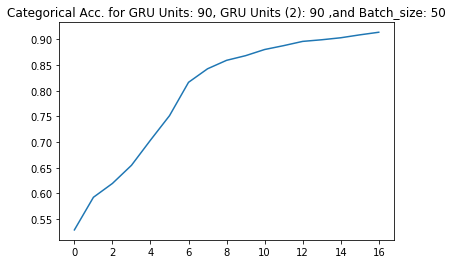

In [19]:
rnn_model = create_rnn_model(X_train_pure)
rnn_model.summary()

compile_model(rnn_model)
train_model(rnn_model, X_train_pure, y_train_rs, 
                        X_val_pure, y_val_rs)

In [20]:
y_pred = get_y_predict(rnn_model, X_test_pure)

In [21]:
def convert_y(y):
  y_conv = [j for i in range(len(y)) for j in range(len(y[i][0])) if y[i][0][j]==np.amax(y[i][0])]
  return np.array(y_conv)

In [22]:
y_t = convert_y(y_test_rs)
y_p = convert_y(y_pred)
      
print("GRU units: ", GRU_UNITS)
print('GRU units 2: ', GRU_UNITS_2)
print("Batch size: ", BATCH_SIZE)
print()
  
acc_score = accuracy_score(y_t, y_p)

print("Accuracy: ", acc_score)

GRU units:  90
GRU units 2:  90
Batch size:  50

Accuracy:  0.58642338630567


In [23]:
print(y_p)
print(y_t)

[0 0 0 ... 4 3 3]
[0 0 0 ... 4 4 4]


In [24]:
%run eval_score.ipynb

In [25]:
LABELS = list(label_dict.values())
print(LABELS)

['sit', 'sleep', 'stand', 'stairs', 'walk']


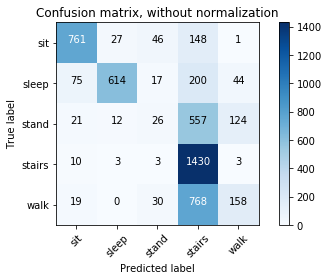

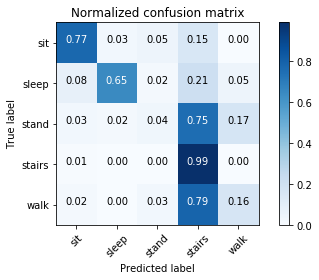

              precision    recall  f1-score   support

         sit       0.86      0.77      0.81       983
       sleep       0.94      0.65      0.76       950
       stand       0.21      0.04      0.06       740
      stairs       0.46      0.99      0.63      1449
        walk       0.48      0.16      0.24       975

   micro avg       0.59      0.59      0.59      5097
   macro avg       0.59      0.52      0.50      5097
weighted avg       0.59      0.59      0.53      5097



In [26]:
show_conf_matrix(y_t, y_p, LABELS)
show_clf_report(y_t, y_p, LABELS)